# Anomaly Detection Using RNN

Anomaly detection detects data points in data that does not fit well with the rest of data. In this notebook we demonstrate how to do unsupervised anomaly detection using recurrent nueral network (RNN) model.

We used one of the dataset in Numenta Anomaly Benchmark (NAB) ([link](https://github.com/numenta/NAB)) for demo, i.e. the ambient temperature data in an office setting, which contains 7267 temperature values in time sequence . We use RNN to learn from 50 previous values, and predict just the 1 next value. The data points whose actual values are distant from predicted values are considered anomalies (distance threshold can be adjusted as needed).
  
References: 
* A Keras implementation of Anomaly Detection using RNN([notebook](https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection)).
* Unsupervised real-time anomaly detection for streaming data ([link](https://www.sciencedirect.com/science/article/pii/S0925231217309864)).

## Intialization

* import necesary libraries

In [1]:
import os
import time

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


* import necessary modules

In [2]:
from zoo.pipeline.api.keras.layers import Dense, Dropout, LSTM
from zoo.pipeline.api.keras.models import Sequential

## Data Check

* read data

In [3]:
try:
    dataset_path = os.getenv("ZOO_HOME")+"/data/ambient_temperature_system_failure/ambient_temperature_system_failure.csv"
    df = pd.read_csv(dataset_path)
except Exception as e:
    print("ambient_temperature_system_failure.csv doesnt exist")
    print("you can run $ZOO_HOME/data/ambient_temperature_system_failure/get_ambient_temperature_system_failure.sh to download ambient_temperature_system_failure.csv")

* Understand the data.

Each record is in format of (timestamp, value). Timestamps range between 2013/07 and 2014/06. Values range between 57 and 87 fahrenheit.

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
timestamp    7267 non-null object
value        7267 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.6+ KB
None


In [5]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [6]:
# check the temperature mean
print(df['value'].mean())

71.2424327083


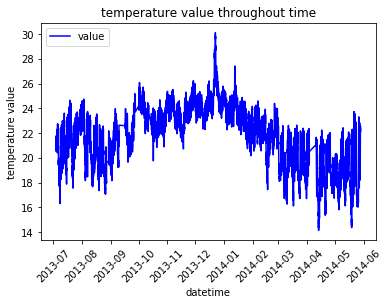

In [7]:
# change the type of timestamp column for plotting
df['datetime'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

ax.plot(df['datetime'], df['value'], color='blue')
ax.set_title('temperature value throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('temperature value')
plt.legend(loc='upper left')
plt.show()

## Feature engineering

* Extracting some useful features

In [8]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['datetime'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [9]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['datetime'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

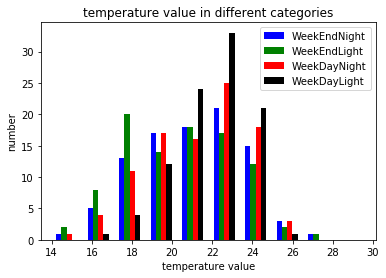

In [10]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')
ax.set_title('temperature value in different categories')

plt.xlabel('temperature value')
plt.ylabel('number')
plt.legend()
plt.show()

From the above result, we can see that the temperature is more stable during daylight of business day.

## Data Preparation

* Standardizing data and spliting them into the train data and the test data

In [11]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

#important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

#test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

* Unroll data: for the data point at index i, create a sequence from i to (i+unroll_length)

ie if unroll_length = 5

[[1]

 [2]
 
 [3]
 
 [4]
 
 [5]
 
 [6]
 
 [7]
 
 [8]
 
 [9]
 
 [10]
 
...

]

will be unrolled to create following sequences

[[ 1,  2,  3,  4,  5]

 [ 2,  3,  4,  5,  6]
 
 [ 3,  4,  5,  6,  7]
 
 [ 4,  5,  6,  7,  8]

 [ 5,  6,  7,  8,  9]
 
 [ 6,  7,  8,  9,  10]
 
 ...
 
 ]

In [12]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

('x_train', (6165, 50, 5))
('y_train', (6165,))
('x_test', (1000, 50, 5))
('y_test', (1000,))


## Build Model

* Here we show an example of building a RNN network using ZOO Sequential API. 
There are three LSTM layers and one Dense layer.

In [13]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_shape=(x_train.shape[1], x_train.shape[-1]),
    output_dim=8,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    32,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    15,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))

start = time.time()
# TODO: remove useless metrics=['accuracy'] after the corresponding apis are updated.
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
print('compilation time : {}'.format(time.time() - start))

creating: createZooKerasSequential
creating: createZooKerasLSTM
creating: createZooKerasDropout
creating: createZooKerasLSTM
creating: createZooKerasDropout
creating: createZooKerasLSTM
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createRMSprop
creating: createMSECriterion
creating: createTop1Accuracy
compilation time : 0.00629591941833


## Train the model

In [14]:
%%time
# Train the model
print("Training begins.")
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=30,
    validation_data=(x_test, y_test))
print("Training completed.")

Training begins.
Training completed.
CPU times: user 82 ms, sys: 22 ms, total: 104 ms
Wall time: 1min 50s


## Prediction

* BigDL models make inferences based on the given data using model.predict(val_rdd) API. A result of RDD is returned. predict_class returns the predicted points. 

In [15]:
# create the list of difference between prediction and test data
diff=[]
ratio=[]
predictions = model.predict(x_test)
p = predictions.collect()
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

## Evaluation

* plot the prediction and the reality

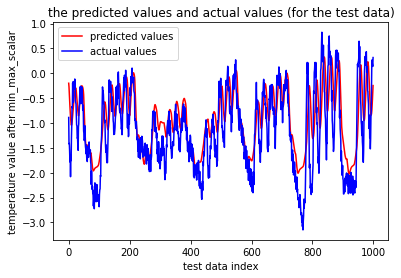

In [16]:
# plot the predicted values and actual values (for the test data)
fig, axs = plt.subplots()

axs.plot(p,color='red', label='predicted values')
axs.plot(y_test,color='blue', label='actual values')
axs.set_title('the predicted values and actual values (for the test data)')

plt.xlabel('test data index')
plt.ylabel('temperature value after min_max_scalar')
plt.legend(loc='upper left')
plt.show()

* Set the distance thresold for anomalies. There're many ways to select this threshold. Here we set the expected proportion of anomalies among the entire set. Then we set the threshold as the minimum value of top N distances (here N is the total number of anomalies, i.e. anomaly fraction * total no. of samples)

In [17]:
# An estimation of anomly population of the dataset
outliers_fraction = 0.01
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

* plot the difference and the threshold.

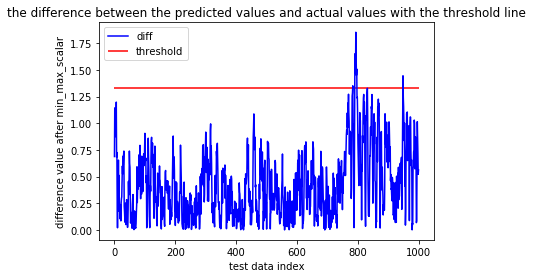

In [18]:
# plot the difference and the threshold (for the test data)
fig, axs = plt.subplots()

axs.plot(diff,color='blue', label='diff')
axs.set_title('the difference between the predicted values and actual values with the threshold line')

plt.hlines(threshold, 0, 1000, color='red', label='threshold')
plt.xlabel('test data index')
plt.ylabel('difference value after min_max_scalar')
plt.legend(loc='upper left')
plt.show()

In [19]:
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
last_train_data= (df['datetime'].tolist())[-testdatasize]
# add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')

* plot anomalies in the test data throughout time

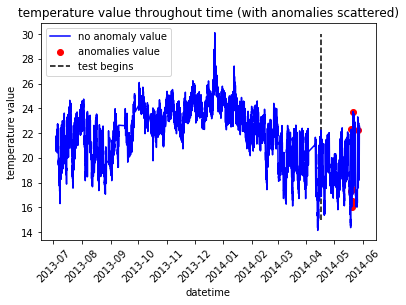

In [20]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['datetime', 'value']] #anomaly
ax.plot(df['datetime'], df['value'], color='blue', label='no anomaly value')
ax.scatter(a['datetime'].tolist(),a['value'], color='red', label='anomalies value')
ax.set_title('temperature value throughout time (with anomalies scattered)')

plt.vlines(last_train_data, 15, 30, color='black', linestyles = "dashed", label='test begins')
plt.xlabel('datetime')
plt.xticks(rotation=45)
plt.ylabel('temperature value')
plt.legend(loc='upper left')
plt.show()